In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm_notebook
import torch
import torchvision

## Dataset MNIST con `torchvision`

MNIST es un dataset de dígitos manuscritos con 70.000 ejemplos compuesto por Yann Lecun y usado como benchmark para algoritmos de visión computacional desde 1998: http://yann.lecun.com/exdb/mnist/

Podemos usar el módulo [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html) para descargar MNIST y otros datasets típicos de benchmark. Los datasets heredan de `torch.utils.data.Dataset`

60000

torch.Tensor

int

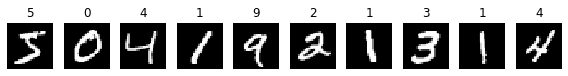

In [2]:
mnist_train_data = torchvision.datasets.MNIST('dataset', train=True, download=True, 
                                              transform=torchvision.transforms.ToTensor())

image, label = mnist_train_data[0]
display(len(mnist_train_data), type(image), type(label))
fig, ax = plt.subplots(1, 10, figsize=(8, 2), tight_layout=True)
for k in range(10):
    image, label = mnist_train_data[k]
    ax[k].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[k].axis('off');
    ax[k].set_title(label)

### Por defecto los labels están en tipo entero y las imágenes en formato [PIL/Pillow](https://pillow.readthedocs.io/en/stable/)

Pillow es una librería ampliamente usada para lectura, escritura y manipulación de imágenes

Usamos la transformación [`ToTensor()`](https://pytorch.org/docs/stable/torchvision/transforms.html) para 
- Convertirlo en tipo torch
- Formatearlo a `float32` con píxeles en $[0,1]$
- Dimensionarlo como [C, H, W], es decir canales x alto x ancho

# Filtros y Convolución bidimensional

Usaremos [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) para visualizar el efecto de algunos filtros simples

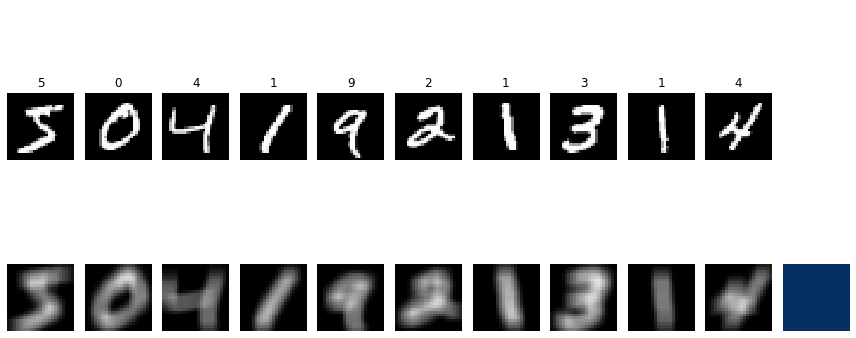

In [3]:
import scipy.signal

filtro = np.array([[1., -1]]).T
filtro = np.ones(shape=(6, 6))
#filtro = np.zeros(shape=(28, 28)); 
#X, Y = np.meshgrid(np.arange(filtro.shape[0]), np.arange(filtro.shape[1]))
#filtro[((X-14)**2 + (Y-14)**2 > 5**2) & ((X-14)**2 + (Y-14)**2 < 7**2) ] = 1
if np.sum(filtro) > 0:
    filtro = filtro/np.sum(filtro)

fig, ax = plt.subplots(2, 11, figsize=(12, 6), tight_layout=True)
for k in range(10):
    image, label = mnist_train_data[k]
    np_image = image.numpy()[0, :, :]
    cv_image = np.absolute(scipy.signal.convolve2d(np_image, filtro, mode='valid'))
    ax[1, k].imshow(cv_image, cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax[1, k].axis('off'); ax[0, k].axis('off');
    ax[0, k].set_title(label)
    ax[0, k].imshow(np_image, cmap=plt.cm.Greys_r)
    
ax[0, 10].axis('off')
ax[1, 10].axis('off')
ax[1, 10].imshow(filtro, cmap=plt.cm.RdBu_r);

#### Alternativa: Si tienes un dataset como matriz NumPy puedes usar `TensorDataset`

In [ ]:
"""
from sklearn.datasets import fetch_openml
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
mnist_train_data = TensorDataset(torch.from_numpy(X_train.astype('float32')),
                                 torch.from_numpy(y_train.astype('int64')))
"""

## Torch DataLoaders

Como vimos la clase pasada necesitamos un `DataLoader` para alimentar nuestras redes neuronales

Un `DataLoader` se crea a partir de un torch `DataSet` y opcionalmente un torch `DataSampler`

Este último especifica como se extraen los datos (aleatoreo, ponderado, etc)

La documentación del modulo `data`: https://pytorch.org/docs/stable/data.html

# Redes Neuronales Convolucionales

Estudie la documentación de [`torch.nn`](https://pytorch.org/docs/stable/nn.html).

Escriba una clase que herede de `torch.nn.Module` para clasificar MNIST (10 clases)

Implemente
1. Una red convolucional con arquitectura Lenet5
1. Agregue dropout
1. Aumentación de datos en el conjunto de entrenamiento (puede usar las transformaciones de torchvision)

Para cada red
- Visualice los filtros obtenidos en las primeras tres capas, ¿puede encontrar los filtros asociados a cada clase?
- Mida el costo de entrenamiento y validación
- Use early-stopping para detener el entrenamiento
- Evalue la red detenida en el conjunto de prueba, obtenga la loss y una tabla de confusión


Compare y analice sus resultados 

Puede usar la librería [hiddenlayer](https://github.com/waleedka/hiddenlayer) o [tensorboard](https://pytorch.org/docs/stable/tensorboard.html) para visualizar el entrenamiento

In [ ]:
class mi_convnet(torch.nn.Module):
    
    def __init__(self):
        super(mi_convnet, self).__init__()
        self.hidden = torch.nn.Linear(1*28*28, 10)
    
    def forward(self, x):
        return self.hidden(x.reshape(-1, 1*28*28))

In [ ]:
nnet = mi_convnet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()
use_gpu = False
if use_gpu:
    nnet = nnet.cuda()

# Hiddenlayer objects to track metrics
import hiddenlayer as hl
history1 = hl.History()
canvas1 = hl.Canvas()

#from torch.utils.tensorboard import SummaryWriter
## tensorboard --logdir=/tmp/tensorboard
#writer = SummaryWriter("/tmp/tensorboard/net1")

nepochs = 5
for epoch in range(nepochs): 
    epoch_loss, epoch_acc = 0.0, 0.0
    # Train
    for mbdata, mblabel in train_loader:
        if use_gpu:
            mbdata, mblabel = mbdata.cuda(), mblabel.cuda()
        prediction = nnet(mbdata)
        optimizer.zero_grad()        
        loss = criterion(prediction, mblabel)  
        epoch_loss += loss.item()
        epoch_acc += (prediction.argmax(dim=1) == mblabel).sum().item()        
        loss.backward()
        optimizer.step()
    # Validation
    #writer.add_scalar('Train/Loss', epoch_loss/len(train_idx), epoch)
    #writer.add_scalar('Train/Acc', epoch_acc/len(train_idx), epoch)
    epoch_loss, epoch_acc = 0.0, 0.0
    for mbdata, mblabel in valid_loader:
        if use_gpu:
            mbdata, mblabel = mbdata.cuda(), mblabel.cuda()
        prediction = nnet(mbdata)
        loss = criterion(prediction, mblabel)  
        epoch_loss += loss.item()
        epoch_acc += (prediction.argmax(dim=1) == mblabel).sum().item()        
    #writer.add_scalar('Valid/Loss', epoch_loss/len(valid_idx), epoch)
    #writer.add_scalar('Valid/Acc', epoch_acc/len(valid_idx), epoch)
    history1.log(epoch, loss=epoch_loss/len(valid_idx), accuracy=epoch_acc/len(valid_idx))
    with canvas1: # So that they render together
        canvas1.draw_plot([history1["loss"]])
        canvas1.draw_plot([history1["accuracy"]])
    #time.sleep(0.1)

if use_gpu:
    nnet = nnet.cpu()
    
#writer.add_graph(nnet)

In [ ]:
#writer.close()

Evaluando la red en un dato de test

In [ ]:
image, label = mnist_test_data[202]
y = torch.nn.Softmax(dim=1)(nnet.forward(image.unsqueeze(0)))
display(y)
display(torch.argmax(y))
display(label)

plt.figure()
plt.imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)